**В предоставленном датасете проанализировать несколько
    характеристик и построить набор визуализаций**

Датасет имен
[*https://github.com/wesm/pydata-book/tree/2nd-edition/datasets/babynames*](https://github.com/wesm/pydata-book/tree/2nd-edition/datasets/babynames)

## Подгрузка библиотек

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Подготовка данных

In [3]:
import os
from pathlib import Path

root = Path('babynames')

def update_with_year(df, year):
    df['year'] = year
    return df

columns = ['name', 'gender', 'count']

dfs = [
    update_with_year(pd.read_csv(root / fn, index_col=None, names=columns), int(fn[3:7])) 
    for fn 
    in os.listdir(root) if fn.startswith('yob')
]

babynames = pd.concat(dfs, axis=0, ignore_index=True, sort=False)

babynames['date'] = pd.to_datetime(babynames['year'], format='%Y', errors='ignore')

Сгруппируйте данные по полу и году и визуализируйте общую динамику
рождаемости обоих полов

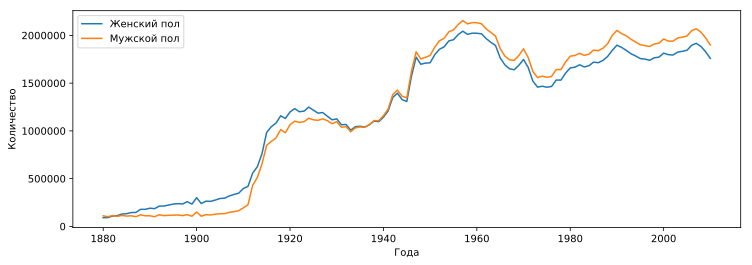

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))

by_gender_and_year = babynames.groupby(['gender', 'year']).sum()

ax.plot(by_gender_and_year.index.levels[1], by_gender_and_year['count']['F'], label='Женский пол')
ax.plot(by_gender_and_year.index.levels[1], by_gender_and_year['count']['M'], label='Мужской пол')

ax.set_xlabel('Года', fontsize = 10)
ax.set_ylabel('Количество', fontsize = 10)

plt.legend()

Найдите самые популярные имена за всю историю

<BarContainer object of 10 artists>

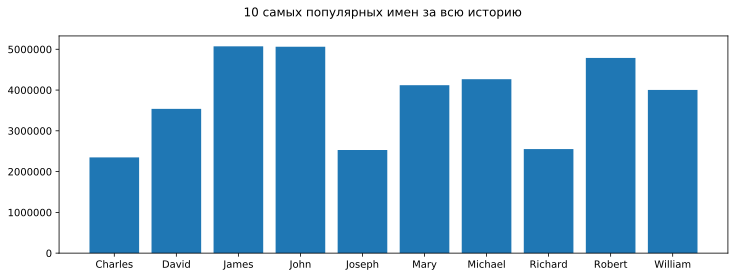

In [4]:
N = 10

fig, ax = plt.subplots(1, 1, figsize=(12,4))
fig.suptitle('{} самых популярных имен за всю историю'.format(N))

by_name = babynames.groupby(['name']).sum()
most_popular_names = by_name.nlargest(N, 'count').index
most_popular = babynames[babynames['name'].isin(most_popular_names)]
by_name = most_popular.groupby(['name']).sum()

ax.bar(by_name.index, by_name['count'])

Разбейте весь временной промежуток в данных на 10 частей и для каждой найдите самое популярное имя каждого пола. 
Для каждого найденного имени визуализируйте его динамику за все время

/home/alexander/.virtualenvs/otus-ds/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


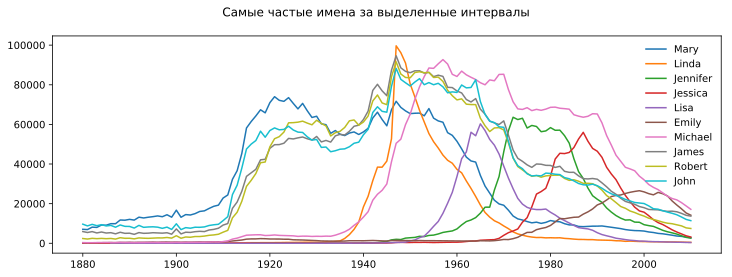

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))
fig.suptitle('Самые частые имена за выделенные интервалы')

N = 10

by_name_and_year = babynames.groupby(['name', 'date']).sum()
parts = list(range(N))
ranges = pd.date_range(start=babynames['date'].min(), end=babynames['date'].max(), periods=N+1)
intervals = list(zip(ranges[:-1], ranges[1:]))
part_names = babynames
part_names['part'] = part_names['date'].map(
    lambda x: [i for i, interval in enumerate(intervals) if interval[0] <= x <= interval[1]][0]
) 

by_gender_and_name_and_year_and_part = part_names.groupby(['gender', 'name', 'part', 'date']).sum()

females = []
males = []
for part in range(len(parts)):
    by_part = by_gender_and_name_and_year_and_part.xs(part, level=2).droplevel([2])
    females.append(by_part.xs('F', level=0).nlargest(1, 'count').iloc[0].name)
    males.append(by_part.xs('M', level=0).nlargest(1, 'count').iloc[0].name)

for gender in ['F', 'M']:
    by_name_and_year = by_gender_and_name_and_year_and_part.xs(gender, level=0).droplevel([1])
    for name in {'F': set(females), 'M': set(males)}[gender]:
        counts = by_name_and_year.xs(name, level=0)['count']
        plt.plot(counts.index, counts, label=name)
    
plt.legend(loc=1, fontsize=10, frameon=False)

Для каждого года рассчитайте сколько имен покрывают 50% людей,
визуализируйте (мы увидим разнообразие имен за каждый год)

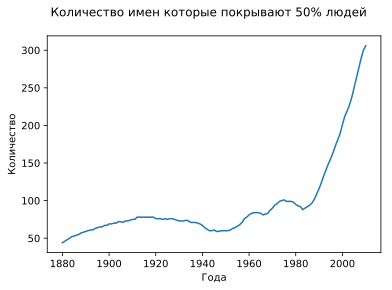

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

counts = []
counts_by_year_and_name = babynames.groupby(['year', 'name']).sum()['count']
for year in counts_by_year_and_name.index.levels[0]:
    counts_by_name_for_year = counts_by_year_and_name[year].sort_values(ascending=False)
    counts_by_name_for_year_cum = counts_by_name_for_year.cumsum()
    counts.append(counts_by_name_for_year_cum[counts_by_name_for_year_cum < counts_by_name_for_year_cum[-1] / 2].size)
    
ax.set_xlabel('Года', fontsize = 10)
ax.set_ylabel('Количество', fontsize = 10)
fig.suptitle('Количество имен которые покрывают 50% людей')
plt.plot(counts_by_year_and_name.index.levels[0], counts)

Выберите 4 года из всего промежутка и отобразите для каждого года
распределение по первой букве в имени, по последней букве в имени

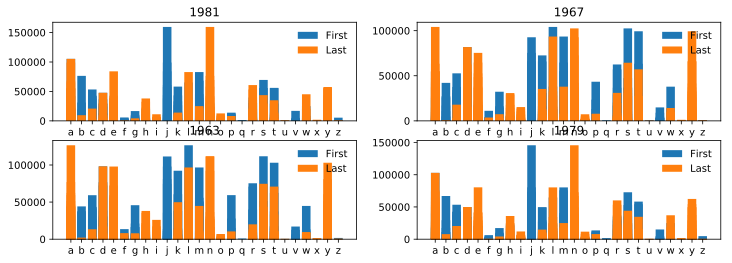

In [7]:
import random

fig, ax = plt.subplots(2, 2, figsize=(12,4))

years = random.choices(babynames.groupby(['year']).sum().index, k=4)  # FIXME

letters = babynames

letters['first'] = babynames['name'].apply(lambda s: s[0].lower())
letters['last'] = babynames['name'].apply(lambda s: s[-1].lower())
by_year_and_first_and_last = babynames.groupby(['year', 'first', 'last']).sum()

for i, year in enumerate(years):
    for droplevel, label in [(2, 'First'), (1, 'Last')]:
        counts = by_year_and_first_and_last.droplevel(droplevel)['count'][year]  # FIXME
        ax[i//2][i%2].bar(counts.index, counts, label=label) 
    ax[i//2][i%2].set_title(year)
    ax[i//2][i%2].legend(loc=1, fontsize=10, frameon=False)

Составьте список из нескольких известных людей (президенты, певцы,
актеры, киногерои) и оцените их влияние на динамику имен, постройте
наглядную визуализацию

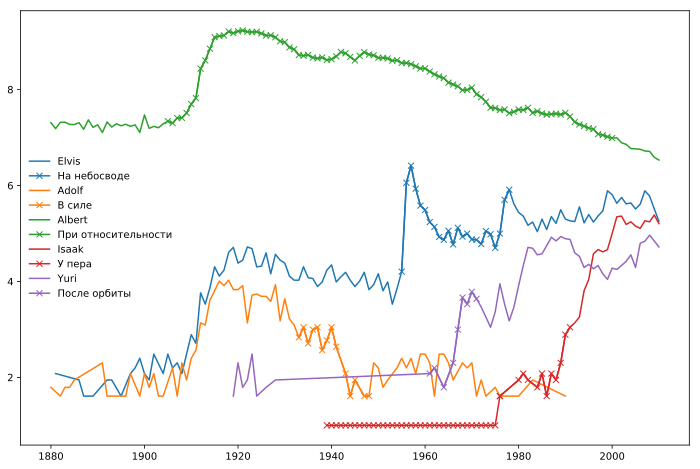

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))

persons = [
    ('Elvis', 1955, 1977, 'На небосводе'),
    ('Adolf', 1933, 1945, 'В силе'),
    ('Albert', 1905, 1999, 'При относительности'),
    ('Isaak', 1939, 1992, 'У пера'),
    ('Yuri', 1961, 1968, 'После орбиты'),
]
g = babynames.groupby(['year']).sum()

n_d = babynames.copy()

n_d['one'] = 1
sum_by_name_and_year = n_d.groupby(['name', 'year']).sum()
mean_by_year = n_d.groupby(['year']).mean()
sum_by_year = n_d.groupby(['year']).sum()

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

for i, (name, left, right, activity) in enumerate(persons):
    by_name = sum_by_name_and_year['count'][name]
    x1, y1 = list(by_name.index), list(np.log(by_name))
    line  = ax.plot(x1, y1, label='{}'.format(name))[0]
    
    past = None
    try:
        idx = x1.index(left)
    except ValueError:
        x2 = list(range(left, x1[0] + 1))
        y2 = [1] * (len(x2) - 1) + [y1[0]]
        try:
            idx = x1.index(right)
        except ValueError:
            pass
        else:
            x2 = x2 + x1[:idx]
            y2 = y2 + y1[:idx]
    else:
        x2 = x1[idx: idx + (right - left + 1) + 1]
        y2 = y1[idx: idx + (right - left + 1) + 1]
    top, bottom = max(y2), min(y2)
    slc = slice(idx, idx + (right - left + 1) + 1)
    ax.plot(x2, y2, color=line.get_color(), marker='x', label=activity)[0]
    plt.legend(loc='best', fontsize=10, frameon=False)